In [ ]:
import datasets
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from datasets import Dataset, DatasetDict
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
import pymorphy2
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


nltk.download('stopwords')

In [2]:
train = pd.read_csv('D:\\Data Science\\Diploma_SER\\project\\text-datasets\\rus-texts\\train_data.csv')
test = pd.read_csv('D:\\Data Science\\Diploma_SER\\project\\text-datasets\\rus-texts\\test_data.csv')

In [3]:
train.head()

,text,labels,emotions
0,Кто носит с собой свечу зажигания,5,neutral
1,«Я потерял контроль» было бы понятным объяснен...,4,anger
2,"Говорит, что миллениалы боятся тяжелой работы,...",3,fear
3,"Это кажется туманным, и были противоречивые со...",5,neutral
4,"Я думаю, что ОД нуждается в доработке. Избавьт...",5,neutral


In [4]:
def plot_emotion_distribution(dataframes, dataframe_names):
  for df, name in zip(dataframes, dataframe_names):
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x='emotions', data=df)
    ax.bar_label(ax.containers[0], fontsize=8)
    plt.title(f'Distribution of Emotions ({name})')
    plt.show()

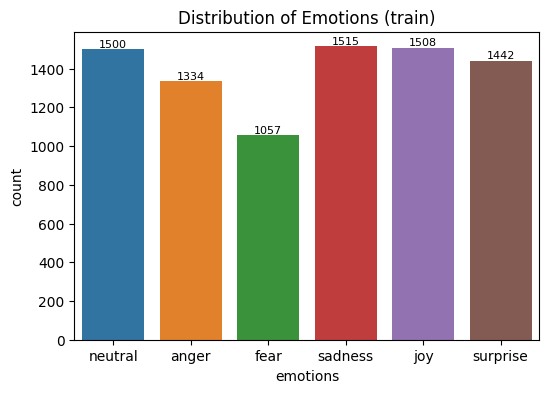

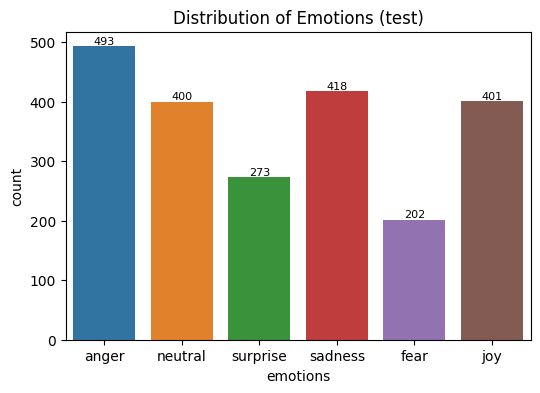

In [5]:
dataframes = [train, test]
dataframe_names = ['train', 'test']

plot_emotion_distribution(dataframes, dataframe_names)

In [6]:
# Removing Duplicate Value
def remove_duplicates(df):
    print('Number of duplicates:', df.duplicated().sum())
    df = df.drop_duplicates(keep='first')
    return df.reset_index(drop=True)

In [7]:
train = remove_duplicates(df=train)
test = remove_duplicates(df=test)

Number of duplicates: 11
Number of duplicates: 1


In [8]:
# Checking if there are rows having the same text but different emotions
print(train["text"].duplicated().sum())
train[train["text"].duplicated() == True].head()

1


,text,labels,emotions
7337,О МОЙ [ИМЯ],2,surprise


In [9]:
print(test["text"].duplicated().sum())
test[test["text"].duplicated() == True].head()

0


,text,labels,emotions


In [10]:
train[train["text"] == train.iloc[7337]["text"]]

,text,labels,emotions
1618,О МОЙ [ИМЯ],5,neutral
7337,О МОЙ [ИМЯ],2,surprise


In [11]:
# Removing Duplicate Value
index = train[train["text"].duplicated() == True].index
train.drop(index,axis=0, inplace=True)
train.reset_index(inplace=True, drop=True)

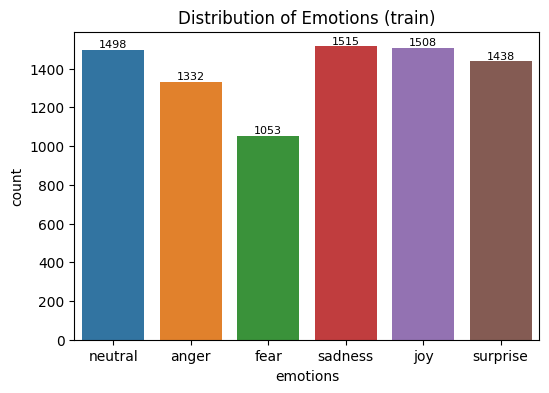

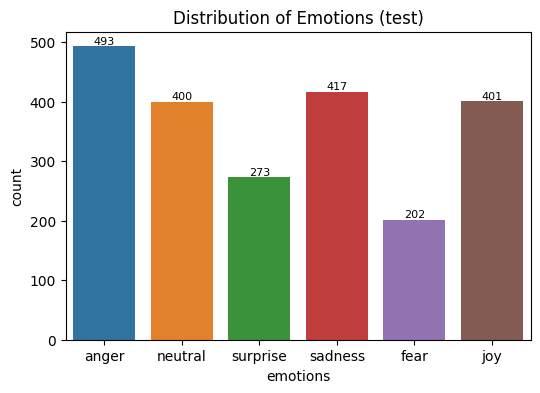

In [12]:
dataframes = [train, test]
dataframe_names = ['train', 'test']

plot_emotion_distribution(dataframes, dataframe_names)

Data preprocessing

In [13]:
def replace_ascii_emoticons(text):
    text = emoji.demojize(text) # Замена эмодзи на текстовые описания
    text = re.sub(r':\w+:', lambda m: f' {m.group(0)[1:-1].upper()} ', text) 
    return text


morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text, morph):
    text = replace_ascii_emoticons(text) 
    text = text.lower()
    text = re.sub(r'http\S+', '', text) 
    text = re.sub(r'<.*?>', '', text) 
    text = re.sub(r'@\w+', '', text) 
    text = re.sub(r'#', '', text) 
    text = ''.join([i for i in text if not i.isdigit()]) 
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9 ]', '', text)

    words = text.split()
    words = [word for word in words if word not in stopwords.words('russian')]
    words = [morph.parse(word)[0].normal_form for word in words]
    text = ' '.join(words)
    return text

In [14]:
train["text"] = train["text"].apply(preprocess_text, args=(morph,))
test["text"] = test["text"].apply(preprocess_text, args=(morph,))


# train-test-val
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train['text'], train['emotions'], test_size=0.1, random_state=42
)

test_texts, test_labels = test["text"], test["emotions"]

In [28]:
def evaluate_classification_performance(true_labels, predicted_labels, train):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    cm = confusion_matrix(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")

    print(classification_report(true_labels, predicted_labels))

    # Visualization - Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=train['emotions'].unique(), 
                yticklabels=train['emotions'].unique())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


def plot_training_history(history):
  plt.figure(figsize=(15, 5)) 
  
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy') 
  plt.title('Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss') 
  plt.title('Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()

  plt.show()

LSTM

In [18]:
# Токенизация текста
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>') 
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

# Приведение последовательностей к одинаковой длине (padding)
max_length = 100 
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')

# Кодирование меток эмоций (one-hot encoding)
emotions = train['emotions'].unique().tolist()
emotion_to_index = {emotion: index for index, emotion in enumerate(emotions)}
index_to_emotion = {index: emotion for index, emotion in enumerate(emotions)}

train_labels_encoded = np.array([emotion_to_index[emotion] for emotion in train_labels])
test_labels_encoded = np.array([emotion_to_index[emotion] for emotion in test_labels])
val_labels_encoded = np.array([emotion_to_index[emotion] for emotion in val_labels])


train_labels_encoded = to_categorical(train_labels_encoded, num_classes=len(emotions))
test_labels_encoded = to_categorical(test_labels_encoded, num_classes=len(emotions))
val_labels_encoded = to_categorical(val_labels_encoded, num_classes=len(emotions))

In [ ]:
model = Sequential()
model.add(Embedding(5000, 128, input_length=max_length)) 
model.add(LSTM(128)) 
model.add(Dropout(0.2)) 
model.add(Dense(len(emotions), activation='sigmoid')) 

optimizer = Adam(learning_rate=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('emotion_text_model_v1.keras', monitor='val_accuracy', save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(
    train_padded, 
    train_labels_encoded, 
    epochs=20, 
    batch_size=32, 
    validation_data=(val_padded, val_labels_encoded),
    callbacks=[early_stopping, model_checkpoint]
)

69/69 [==============================] - 1s 16ms/step
Accuracy: 0.18344007319304667
Precision: 0.03365026045307032
Recall: 0.18344007319304667
F1-score: 0.056868549942336075


d:\Data Science\Diploma_SER\env_cuda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


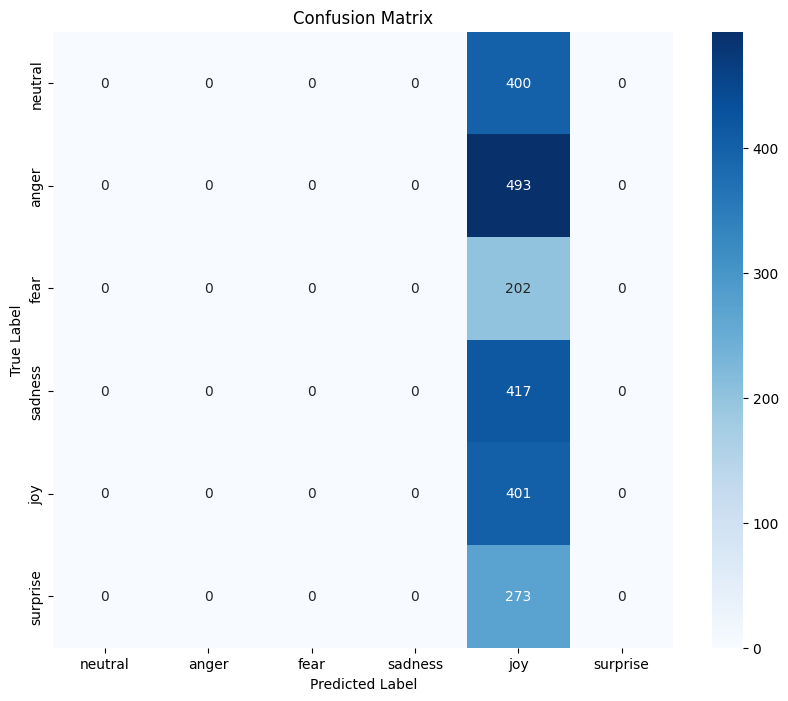

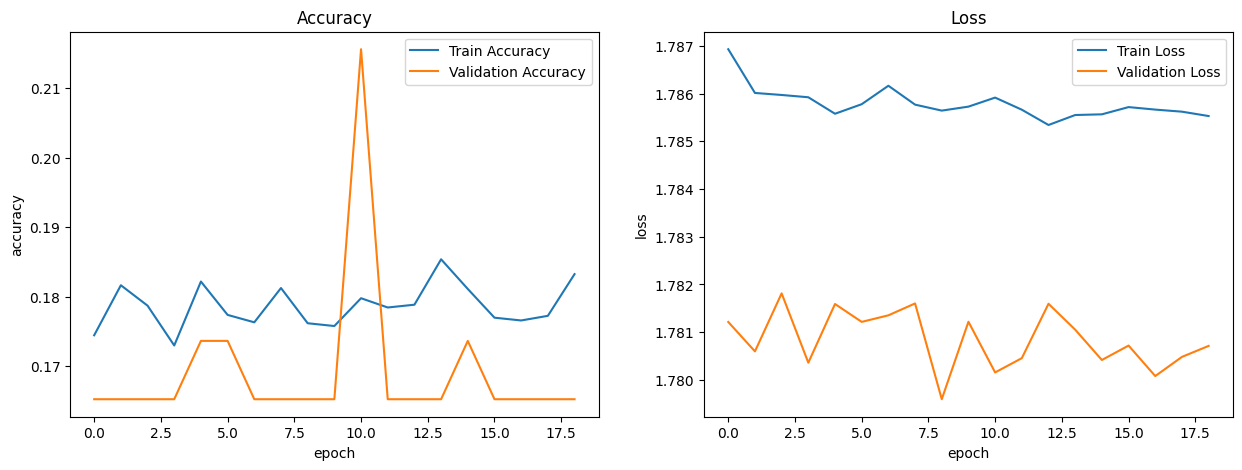

In [214]:
predictions = model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1) 
true_labels = np.argmax(test_labels_encoded, axis=1)

evaluate_classification_performance(true_labels, predicted_labels, train)
plot_training_history(history)

Дообучение

In [ ]:
num_emotions = len(train['emotions'].unique())

# Загрузка модели
model_name = "DeepPavlov/rubert-base-cased-conversational" 
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_emotions) 
tokenizer = AutoTokenizer.from_pretrained(model_name)


df_train = train[['text', 'labels']]
df_test = test[['text', 'labels']] 


# Создание набора данных Hugging Face
dataset = Dataset.from_pandas(df_train) 
dataset_test = Dataset.from_pandas(df_test)

# Токенизация
def tokenize_function(examples):
    return tokenizer(
        examples["text"], 
        padding="max_length", 
        truncation=True,
        max_length=40
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets_test = dataset_test.map(tokenize_function, batched=True)


# train-test-val
train_valid = tokenized_datasets.train_test_split(test_size=0.2, seed=42)

tokenized_datasets = DatasetDict({
    'train': train_valid['train'],
    'test': tokenized_datasets_test,
    'validation': train_valid['test']
})

In [25]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=8,
    num_train_epochs=3, 
    learning_rate=2e-5, 
    weight_decay=0.01, 
    eval_strategy="epoch", 
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs', 
    logging_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

  0%|          | 0/2505 [00:00<?, ?it/s]

{'loss': 1.1399, 'grad_norm': 27.175737380981445, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


  0%|          | 0/209 [00:00<?, ?it/s]

{'eval_loss': 0.9078201651573181, 'eval_runtime': 7.1331, 'eval_samples_per_second': 233.978, 'eval_steps_per_second': 29.3, 'epoch': 1.0}
{'loss': 0.671, 'grad_norm': 2.1490373611450195, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/209 [00:00<?, ?it/s]

{'eval_loss': 0.9473615884780884, 'eval_runtime': 6.7838, 'eval_samples_per_second': 246.027, 'eval_steps_per_second': 30.809, 'epoch': 2.0}
{'loss': 0.4201, 'grad_norm': 0.663796067237854, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/209 [00:00<?, ?it/s]

{'eval_loss': 1.0667200088500977, 'eval_runtime': 9.4777, 'eval_samples_per_second': 176.097, 'eval_steps_per_second': 22.052, 'epoch': 3.0}
{'train_runtime': 1673.2435, 'train_samples_per_second': 11.968, 'train_steps_per_second': 1.497, 'train_loss': 0.7436768796391592, 'epoch': 3.0}


TrainOutput(global_step=2505, training_loss=0.7436768796391592, metrics={'train_runtime': 1673.2435, 'train_samples_per_second': 11.968, 'train_steps_per_second': 1.497, 'total_flos': 411639696036000.0, 'train_loss': 0.7436768796391592, 'epoch': 3.0})

  0%|          | 0/274 [00:00<?, ?it/s]

Accuracy: 0.681152790484904
Precision: 0.6907751415929302
Recall: 0.681152790484904
F1-score: 0.6796084800003213
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       401
           1       0.73      0.58      0.65       417
           2       0.63      0.80      0.70       273
           3       0.72      0.82      0.77       202
           4       0.69      0.61      0.64       493
           5       0.60      0.76      0.67       400

    accuracy                           0.68      2186
   macro avg       0.69      0.70      0.69      2186
weighted avg       0.69      0.68      0.68      2186



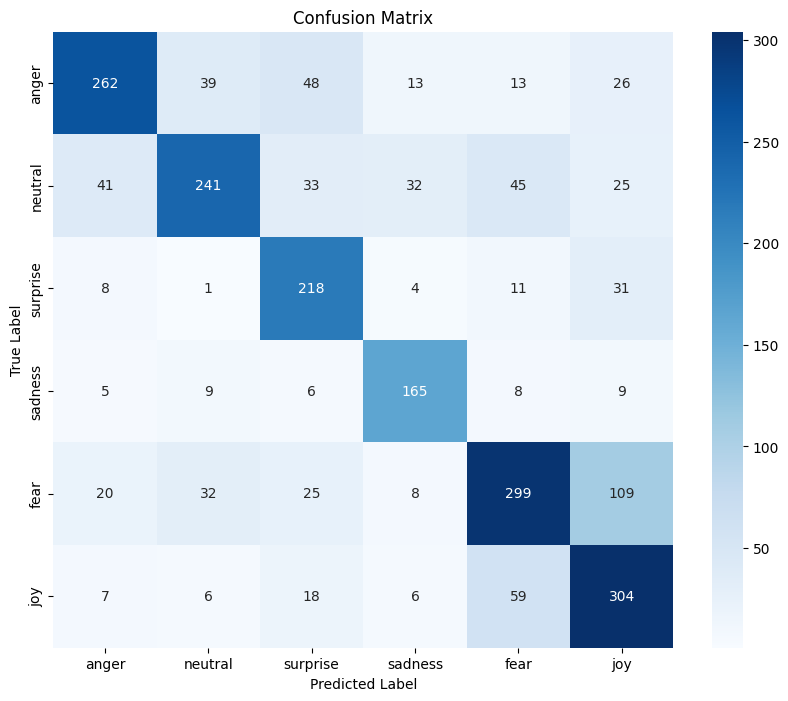

In [29]:
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = np.argmax(predictions.predictions, axis=1)

evaluate_classification_performance(tokenized_datasets["test"]["labels"], predicted_labels, test)

In [30]:
# Save model
trainer.save_model("D:\\Data Science\\Diploma_SER\\project\\notebooks\\text-models\\rus_data\\text-emotion-model") 
tokenizer.save_pretrained("D:\\Data Science\\Diploma_SER\\project\\notebooks\\text-models\\rus_data\\text-emotion-model")

('D:\\Data Science\\Diploma_SER\\project\\notebooks\\text-models\\rus_data\\text-emotion-model\\tokenizer_config.json',
 'D:\\Data Science\\Diploma_SER\\project\\notebooks\\text-models\\rus_data\\text-emotion-model\\special_tokens_map.json',
 'D:\\Data Science\\Diploma_SER\\project\\notebooks\\text-models\\rus_data\\text-emotion-model\\vocab.txt',
 'D:\\Data Science\\Diploma_SER\\project\\notebooks\\text-models\\rus_data\\text-emotion-model\\added_tokens.json',
 'D:\\Data Science\\Diploma_SER\\project\\notebooks\\text-models\\rus_data\\text-emotion-model\\tokenizer.json')